Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

### Importing Skin Cancer Data


In [2]:
#Using kaggle for this case study so that the GPU power can be leveraged and as Google colab has lot of issues while performing this case study
#as it signs out automatically after a time period if there is no user interaction.
#Hence, input directory of kaggle is used for uploading the dataset and the output folder is used to store the images which are generated
# while avoiding class imbalancing at a later stage during model 3 building.
data_dir_train = pathlib.Path("../input/skincancerdataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("../input/skincancerdataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-11-16 15:10:01.059750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:10:01.201490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:10:01.202390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:10:01.204847: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

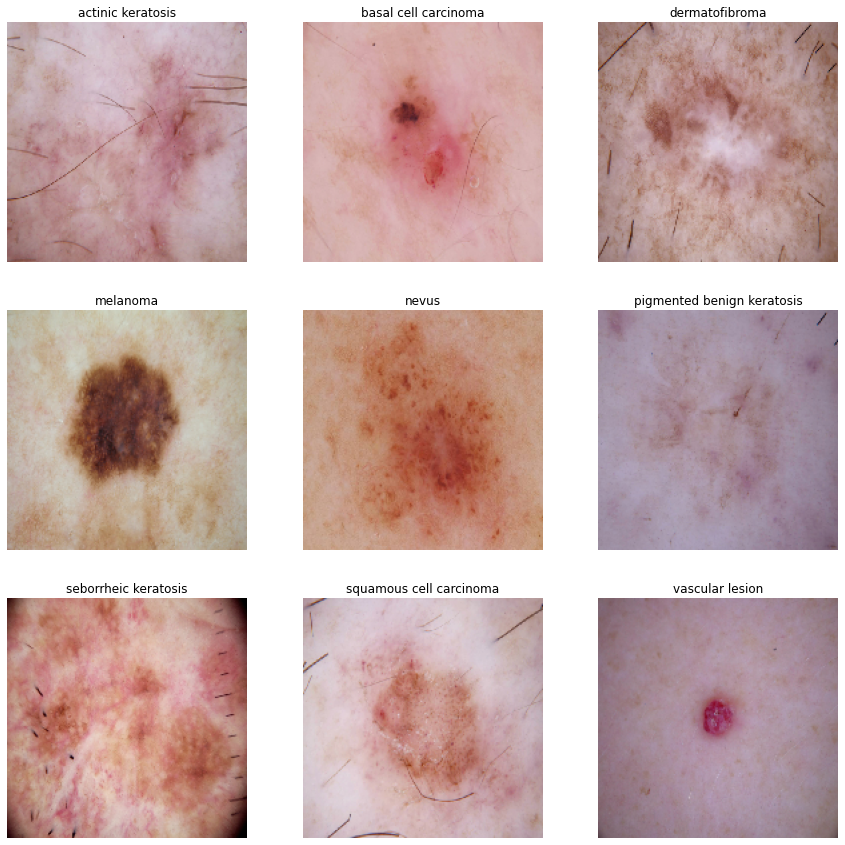

In [8]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

# Model M1

In [10]:
## Number of classes is 9
num_class = 9
input_shape = (img_height,img_width,3)

model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(32,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(128,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Flatten(),
    
    layers.Dense(512,activation='relu'),
    layers.Dense(num_class,activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [13]:
epochs = 20
history = model.fit(
    train_ds,
    verbose=1,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


2022-11-16 15:10:06.090746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-16 15:10:16.365104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 29 of 1000
2022-11-16 15:10:21.247127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-16 15:10:22.107476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 28s 106ms/step - loss: 2.3045 - accuracy: 0.1908 - val_loss: 1.9638 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.9296 - accuracy: 0.2824 - val_loss: 1.8388 - val_accuracy: 0.3199
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7075 - accuracy: 0.3756 - val_loss: 1.6171 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4997 - accuracy: 0.4883 - val_loss: 1.5852 - val_accuracy: 0.4139
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3313 - accuracy: 0.5301 - val_loss: 1.4181 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2385 - accuracy: 0.5564 - val_loss: 1.3858 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1209 - accuracy: 0.6060 - val_loss: 1.4337 - val_accuracy: 0.5235
Epoch 8/20
56/56 [====

### Visualizing training results

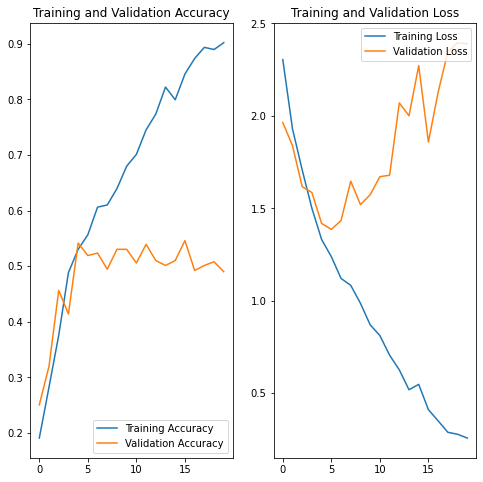

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Overfit or Underfit?


In [15]:
loss_train, accuracy_train = model.evaluate(train_ds, verbose=1)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy_train)
print("Validation Accuracy: ",accuracy_val)
print("Training Loss: ",loss_train)
print("Validation Loss", loss_val)

14/14 [==============================] - 0s 9ms/step - loss: 2.3896 - accuracy: 0.4899
Training Accuracy:  0.9168526530265808
Validation Accuracy:  0.4899328947067261
Training Loss:  0.21613545715808868
Validation Loss 2.3896331787109375


OBSERVATION: From the above experimentation with model training, it is evident that the model clearly overfits, and thus we need to chose right data augumentation strategy.

In [16]:
#Resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(180, 180, input_shape = (img_height,img_width,3)),
  layers.Rescaling(1./255)
])

## Data Augmentation layer

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

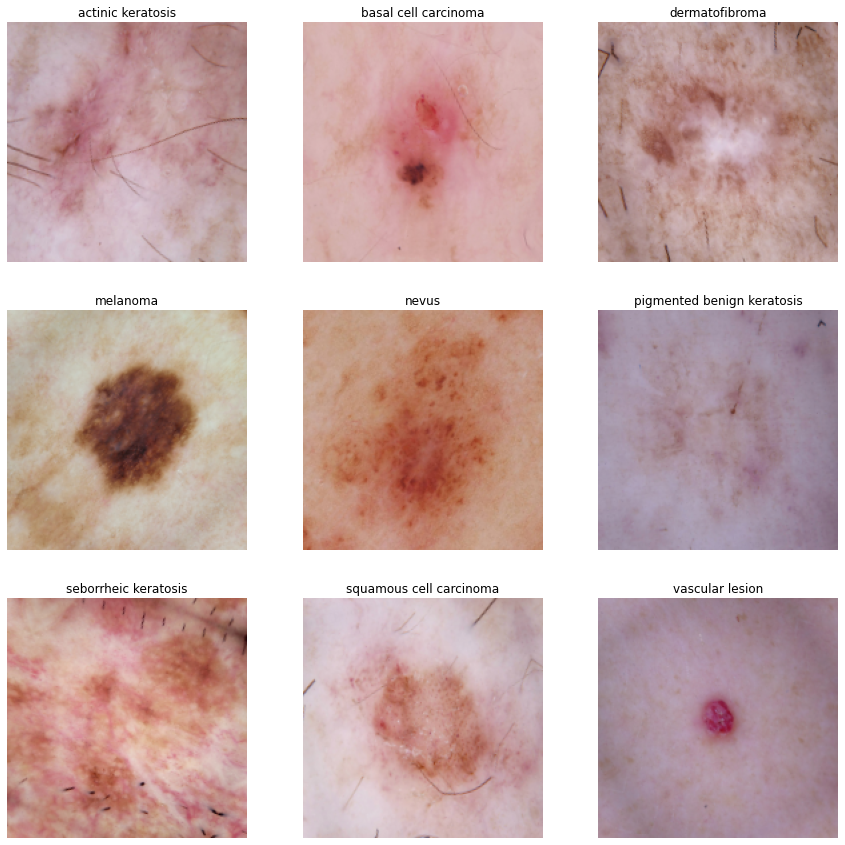

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    res=resize_and_rescale(load_img(path_list[0]))
    augmented_image=data_augmentation(res)
    plt.imshow(augmented_image)
    plt.title(c)
    plt.axis("off")


OBSERVATION: We can clearly see that the images are flipped and rotated.


### Todo:
### Create the model, compile and train the model


# Model M2

In [19]:
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(128,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Flatten(),
    
    layers.Dense(512,activation='relu'),
    layers.Dense(num_class,activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (180, 180, 3)             0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 128)      

### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [21]:
# train your model for 20 epochs
epochs = 20
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 29ms/step - loss: 2.2722 - accuracy: 0.2388 - val_loss: 1.8492 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 1s 27ms/step - loss: 1.8101 - accuracy: 0.3443 - val_loss: 1.6633 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 1s 27ms/step - loss: 1.6145 - accuracy: 0.4208 - val_loss: 1.5638 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5238 - accuracy: 0.4632 - val_loss: 1.5098 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4232 - accuracy: 0.5039 - val_loss: 1.4269 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3671 - accuracy: 0.5134 - val_loss: 1.3954 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 1s 27ms/step - loss: 1.3625 - accuracy: 0.5078 - val_loss: 1.3740 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing the results

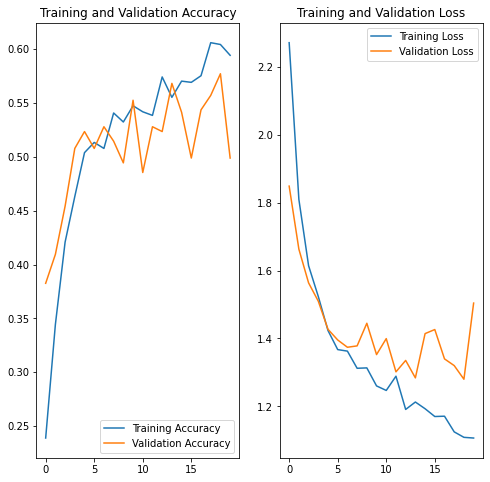

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

OBSERVATION
- Model M2 has definitely reduce the overfitting and has improved using the data augmentation strategy. However, it still underfits as the accuracy is on the lower side.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,melanoma,438
2,vascular lesion,139
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,basal cell carcinoma,376
6,seborrheic keratosis,77
7,dermatofibroma,95
8,nevus,357


<AxesSubplot:xlabel='No. of Image', ylabel='Class'>

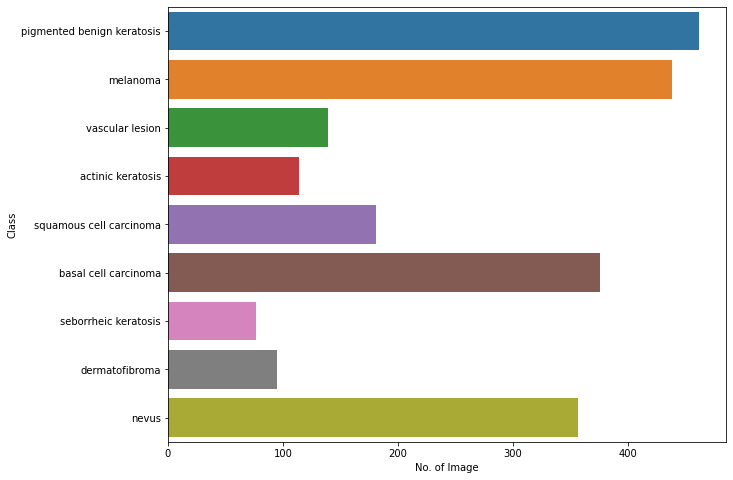

In [24]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


OBSERVATION: 
- There is a class imbalance in the dataset and hence we need to take care of it.
- The class 'seborrheic keratosis' has the least number of samples.
- Classes which dominate the data in terms of proportionate number of samples are 'pigmented benign keratosis', 'melanoma', 'basal cell carcinoma', 'nevus'

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


# Augmentor Library layer code

In [26]:
path_to_training_dataset="../input/skincancerdataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
output_dataset="/output/kaggle/working/"
import Augmentor
for i in class_names:
    p=Augmentor.Pipeline(source_directory=path_to_training_dataset+i,output_directory=output_dataset+i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.4)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /output/kaggle/working/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07C45E7D50>: 100%|██████████| 500/500 [00:15<00:00, 31.31 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /output/kaggle/working/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07E03BF710>: 100%|██████████| 500/500 [00:16<00:00, 29.51 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /output/kaggle/working/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07E0394A50>: 100%|██████████| 500/500 [00:16<00:00, 29.81 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /output/kaggle/working/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F07C46A8A50>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /output/kaggle/working/nevus.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F07C4605190>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /output/kaggle/working/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07C46C8190>: 100%|██████████| 500/500 [00:16<00:00, 30.25 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /output/kaggle/working/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F07C46C8BD0>: 100%|██████████| 500/500 [00:40<00:00, 12.35 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /output/kaggle/working/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07C46D2310>: 100%|██████████| 500/500 [00:15<00:00, 31.84 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /output/kaggle/working/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F07C46015D0>: 100%|██████████| 500/500 [00:17<00:00, 29.16 Samples/s]                  


Augmentor has stored the augmented images in the output directory under each skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
image_count_train=0
for i in class_names:
    data_dir_output = pathlib.Path(output_dataset+i)
    new_list=list(data_dir_output.glob('*.jpg'))
    image_count_train+=len(new_list)
    for x in range(len(new_list)):
                   print(new_list[x])

/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0027580.jpg_ed1d77ba-3b15-479d-8ebd-11f833fcf952.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0033456.jpg_3d11b9c8-fb28-4515-bf3a-8e82ce3fad3e.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0029900.jpg_3d36b121-e263-4782-a932-7895e805ffa5.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0026626.jpg_885e9b3b-b16a-4214-bbaf-f31162fd51a4.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0029210.jpg_629b6815-092c-43b4-9c99-7053b73ac443.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0031823.jpg_0d042efc-c55e-42c8-91de-c2902c1e0a73.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0032854.jpg_cabf0cf6-2d7f-49ff-b92c-f741a4f39854.jpg
/output/kaggle/working/actinic keratosis/actinic keratosis_original_ISIC_0032437.jpg_a3365626-0ce3-415b-baef-d22d81a8c

In [28]:
print("Total images: " + str(image_count_train))

Total images: 4500


In [29]:
#lets see the lesion list
for i in class_names:
    data_dir_output = pathlib.Path(output_dataset+i)
    new_list=list(data_dir_output.glob('*.jpg'))
    print(i + ": " + str(len(new_list)))

actinic keratosis: 500
basal cell carcinoma: 500
dermatofibroma: 500
melanoma: 500
nevus: 500
pigmented benign keratosis: 500
seborrheic keratosis: 500
squamous cell carcinoma: 500
vascular lesion: 500


OBSERVATION
- So, now we have added 500 images to all the classes to maintain some class balance. We can add more images if we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [30]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [31]:
train_ds_input = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [32]:
train_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  output_dataset,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [33]:
#merging the 2 data sets - one from input train dataset and the other from storage having augmented images.
train_ds=train_ds_input.concatenate(train_ds_augmented)

#### **Todo:** Create a validation dataset

In [34]:
val_ds_input = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [35]:
val_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  output_dataset,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [36]:
#merging the 2 data sets - one from input validation dataset and the other from storage having augmented images.
val_ds=val_ds_input.concatenate(val_ds_augmented)

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

# Model M3

In [38]:
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(64,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(128,kernel_size=(3,3),padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Flatten(),
    
    layers.Dense(512,activation='relu'),
    layers.Dense(num_class,activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (180, 180, 3)             0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs = 30
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30


2022-11-16 15:17:34.505210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 57 of 1000


  8/169 [>.............................] - ETA: 4s - loss: 3.0022 - accuracy: 0.1016

2022-11-16 15:17:41.965258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


169/169 [==============================] - 28s 58ms/step - loss: 1.9713 - accuracy: 0.2418 - val_loss: 1.6784 - val_accuracy: 0.3571
Epoch 2/30
169/169 [==============================] - 5s 27ms/step - loss: 1.6607 - accuracy: 0.3615 - val_loss: 1.6076 - val_accuracy: 0.3697
Epoch 3/30
169/169 [==============================] - 4s 26ms/step - loss: 1.5382 - accuracy: 0.3969 - val_loss: 1.4581 - val_accuracy: 0.4388
Epoch 4/30
169/169 [==============================] - 5s 28ms/step - loss: 1.4407 - accuracy: 0.4479 - val_loss: 1.3872 - val_accuracy: 0.4566
Epoch 5/30
169/169 [==============================] - 4s 26ms/step - loss: 1.3770 - accuracy: 0.4655 - val_loss: 1.4104 - val_accuracy: 0.4684
Epoch 6/30
169/169 [==============================] - 5s 27ms/step - loss: 1.3191 - accuracy: 0.4835 - val_loss: 1.3052 - val_accuracy: 0.4826
Epoch 7/30
169/169 [==============================] - 4s 26ms/step - loss: 1.2859 - accuracy: 0.4967 - val_loss: 1.2628 - val_accuracy: 0.5115
Epoch 8/3

#### **Todo:**  Visualize the model results

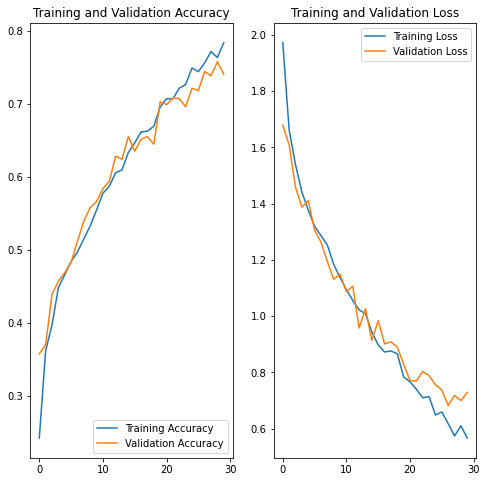

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual Class dermatofibroma
Predictive Class dermatofibroma


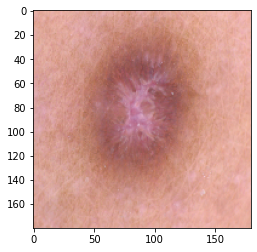

In [42]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[2] +'\n'+ "Predictive Class "+pred_class )


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



OBSERVATION:
- The class rebalance really helped in reducing underfitting of the data and as a result the loss is also taken care of. 
- Also, the accuracy helped us predict the test data set images appropriately to certain extent.